# What drives error?
>Investigating sources of error, per genome:

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [2]:
from src.simulation import simulate_from_ids
from src.torch_solver import TorchSolver, solve_table
from src.database import RnaDB

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

In [3]:
db = RnaDB()

# Simulating and assessing:

## Single-genome solutions:

This analysis has been factored out into the script `large_simulation_experiment`,
which outputs to the file `data/scores/large_simulation_experiment.csv`. I have
commented out the initial analysis for posterity, and instead load directly from
the CSV.

In [3]:
# N_SAMPLES = 10
# SCALE = 1e7

In [4]:
# db = RnaDB()

# results = pd.DataFrame(
#     columns=[
#         "genome",
#         "trial",
#         "a",
#         "b",
#         "a_hat",
#         "b_hat",
#         "final_loss",
#         "a_err",
#         "b_err",
#         "n_reads",
#     ]
# )

# for genome in tqdm(db.complete_genomes):
#     samples, ptrs, abundances, otus = simulate_from_ids(
#         ids=[genome], n_samples=N_SAMPLES, scale=SCALE, verbose=False
#     )
#     solutions = solve_table(otus, [genome], db=db, verbose=False)
#     for idx, (a_hat, b_hat, losses) in enumerate(solutions):
#         a_err = np.abs(
#             np.exp(a_hat[0]) - abundances[0, 0]
#         )  # Not meaninful here
#         b_err = np.abs(np.exp(b_hat[0]) - ptrs[0, 0])
#         results = results.append(
#             {
#                 "genome": genome,
#                 "trial": idx,
#                 "a": abundances[0, idx],
#                 "b": ptrs[0, idx],
#                 "a_hat": a_hat[0],
#                 "b_hat": b_hat[0],
#                 "final_loss": losses[-1],
#                 "a_err": a_err,
#                 "b_err": b_err,
#                 "n_reads": otus[idx].sum(),
#             },
#             ignore_index=True,
#         )


In [10]:
# results.to_csv("../data/scores/what_drives_error_1e7.csv")

results = pd.read_csv("../data/scores/large_simulation_experiment.csv", index_col=0, dtype={"genome": str})
results_old = pd.read_csv("../data/scores/large_simulation_experiment_2x.csv", index_col=0, dtype={"genome": str})

In [5]:
# Verify simulation finished

db = RnaDB()
db.complete_genomes[-1]
assert len(results[results["genome"] == db.complete_genomes[-1]]) > 0

Text(0.5, 0, 'Error median rank')

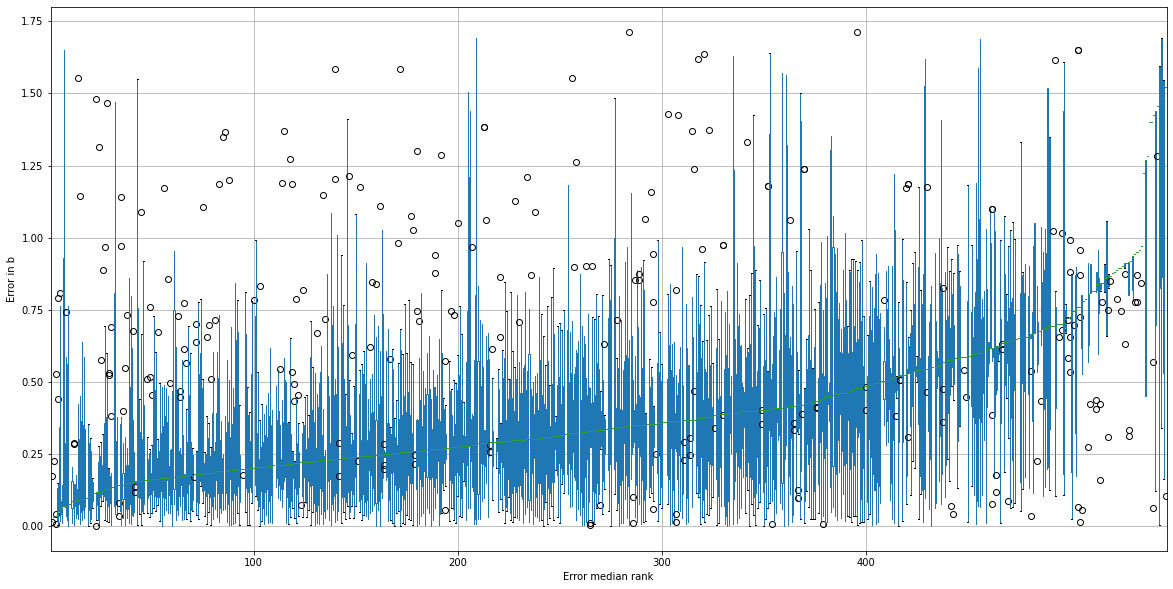

In [8]:
# Boxplot error values
# Borrows from https://stackoverflow.com/questions/21912634/how-can-i-sort-a-boxplot-in-pandas-by-the-median-values

df2 = pd.DataFrame(
    {col:vals["b_err"] for col, vals in results.groupby("genome")}
)
df2 = df2.reindex(df2.median().sort_values().index, axis=1)
df2.boxplot(figsize=(20, 10))
# plt.yscale("log")
plt.xticks(np.arange(100, 500, 100), np.arange(100, 500, 100))
plt.ylabel("Error in b")
plt.xlabel("Error median rank")

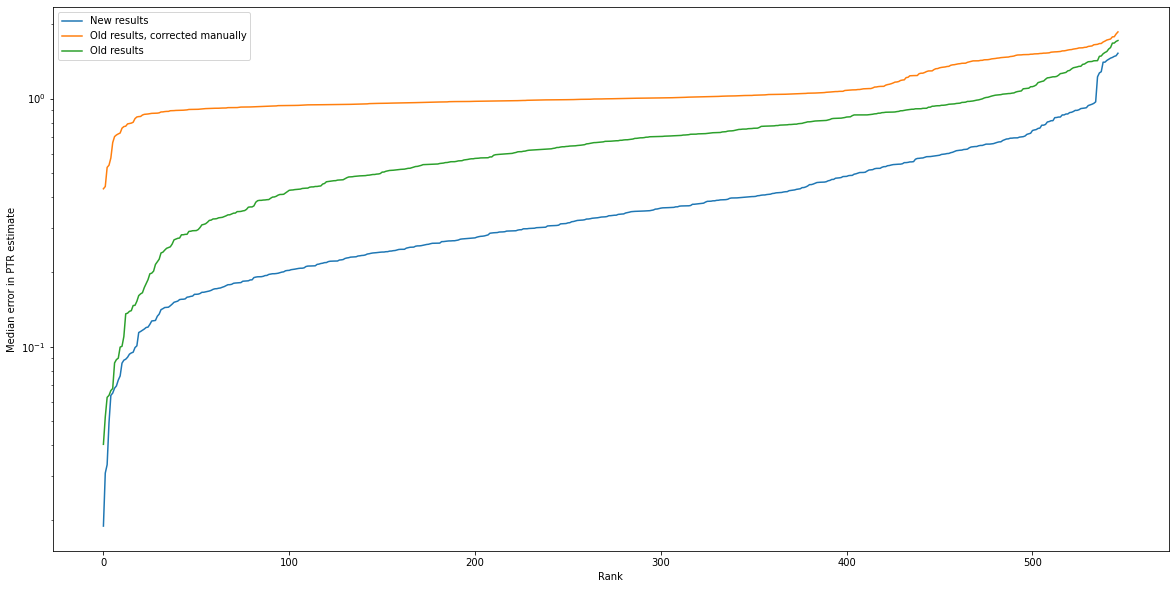

In [33]:
df3 = pd.DataFrame(
    {col:vals["b_err"] for col, vals in results_old.groupby("genome")}
)
df3 = df3.reindex(df3.median().sort_values().index, axis=1)

results_old["corrected_error"] = np.abs(
    .5 * np.exp(results_old["b_hat"]) + .5 - results_old["b"]
)
df4 = pd.DataFrame(
    {col:vals["corrected_error"] for col, vals in results_old.groupby("genome")}
)

fig = plt.figure(figsize=(20, 10))
plt.plot(range(len(df2.columns)), df2.median().sort_values(), label="New results")
plt.plot(range(len(df3.columns)), df4.median().sort_values(), label="Old results, corrected manually")
plt.plot(range(len(df3.columns)), df3.median().sort_values(), label="Old results")
plt.yscale("log")
plt.xlabel("Rank")
plt.ylabel("Median error in PTR estimate")
plt.legend()

In [34]:
results_old

,genome,trial,a,b,a_hat,b_hat,final_loss,a_err,b_err,n_reads,corrected_error
0,398579.7,0,7612996,1.371131,0.654218,0.574916,3.079980e-08,7.612994e+06,0.405851,10564,0.982640
1,398579.7,1,5732545,1.824073,0.455166,1.000000,3.932661e-05,7.612994e+06,1.347151,8684,0.964932
2,398579.7,2,6901421,1.542986,0.685145,0.652671,4.592270e-06,7.612994e+06,0.549532,10047,1.082655
3,398579.7,3,6545181,1.216062,0.770732,0.000000,1.227663e-06,7.612994e+06,0.371131,8715,1.216062
4,398579.7,4,2440055,1.829877,0.718800,0.797054,3.083639e-05,7.612994e+06,0.847863,3719,1.220380
...,...,...,...,...,...,...,...,...,...,...,...
5464,644284.3,5,3627883,1.464908,0.156859,0.654529,1.687919e-06,2.383761e+06,0.713410,4471,1.002790
5465,644284.3,6,931678,1.318680,0.712024,0.393429,1.702083e-05,2.383760e+06,0.271227,1151,1.077653
5466,644284.3,7,7685204,1.084749,0.617034,0.190518,1.016304e-05,2.383760e+06,0.000951,9317,0.979812
5467,644284.3,8,18321271,1.489990,0.143304,0.673257,9.678278e-07,2.383761e+06,0.749786,22276,1.009684


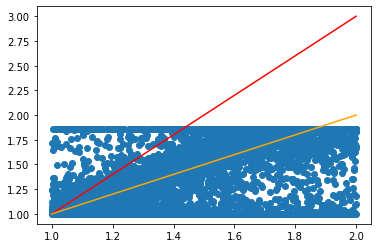

In [32]:
# plt.scatter(results_old["b"], np.exp(results_old["b_hat"]))
plt.scatter(
    results_old["b"],
    .5*np.exp(results_old["b_hat"]) + .5,
)
plt.plot([1,2], [1,3], c='r')
plt.plot([1,2], [1,2], c='orange')

In [21]:
results_old

,genome,trial,a,b,a_hat,b_hat,final_loss,a_err,b_err,n_reads,corrected_error
0,398579.7,0,7612996,1.371131,0.654218,0.574916,3.079980e-08,7.612994e+06,0.405851,10564,2.748823
1,398579.7,1,5732545,1.824073,0.455166,1.000000,3.932661e-05,7.612994e+06,1.347151,8684,2.909008
2,398579.7,2,6901421,1.542986,0.685145,0.652671,4.592270e-06,7.612994e+06,0.549532,10047,2.536109
3,398579.7,3,6545181,1.216062,0.770732,0.000000,1.227663e-06,7.612994e+06,0.371131,8715,2.705707
4,398579.7,4,2440055,1.829877,0.718800,0.797054,3.083639e-05,7.612994e+06,0.847863,3719,2.398963
...,...,...,...,...,...,...,...,...,...,...,...
5464,644284.3,5,3627883,1.464908,0.156859,0.654529,1.687919e-06,2.383761e+06,0.713410,4471,3.434104
5465,644284.3,6,931678,1.318680,0.712024,0.393429,1.702083e-05,2.383760e+06,0.271227,1151,2.393190
5466,644284.3,7,7685204,1.084749,0.617034,0.190518,1.016304e-05,2.383760e+06,0.000951,9317,3.626274
5467,644284.3,8,18321271,1.489990,0.143304,0.673257,9.678278e-07,2.383761e+06,0.749786,22276,3.776932


In [36]:
df2.median().sort_values()

1247649.30    0.040367
309799.40     0.052065
489653.30     0.062429
1215343.11    0.063590
216142.30     0.066485
                ...   
1487956.30    1.605794
1286364.30    1.673054
1131812.30    1.674347
702457.60     1.700287
979556.30     1.714266
Length: 547, dtype: float64

Text(0.5, 1.0, 'PTR predictions can be all over the place')

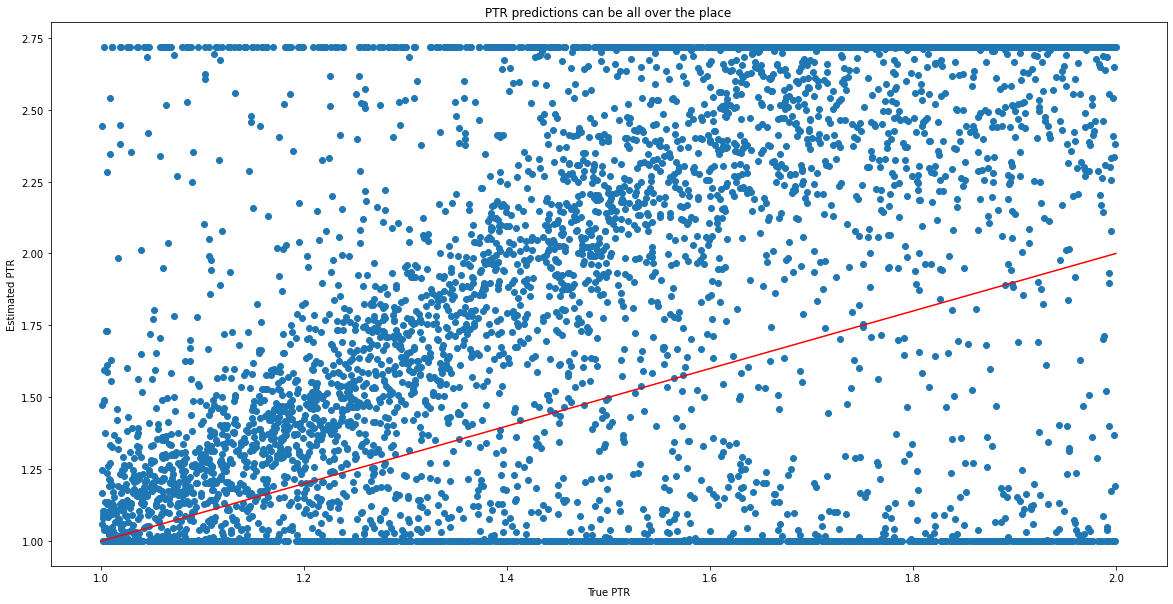

In [7]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(results["b"], np.exp(results["b_hat"]))
plt.plot([1,2], [1,2], color="red")
plt.xlabel("True PTR")
plt.ylabel("Estimated PTR")
plt.title("PTR predictions can be all over the place")

(1e-10, 1)

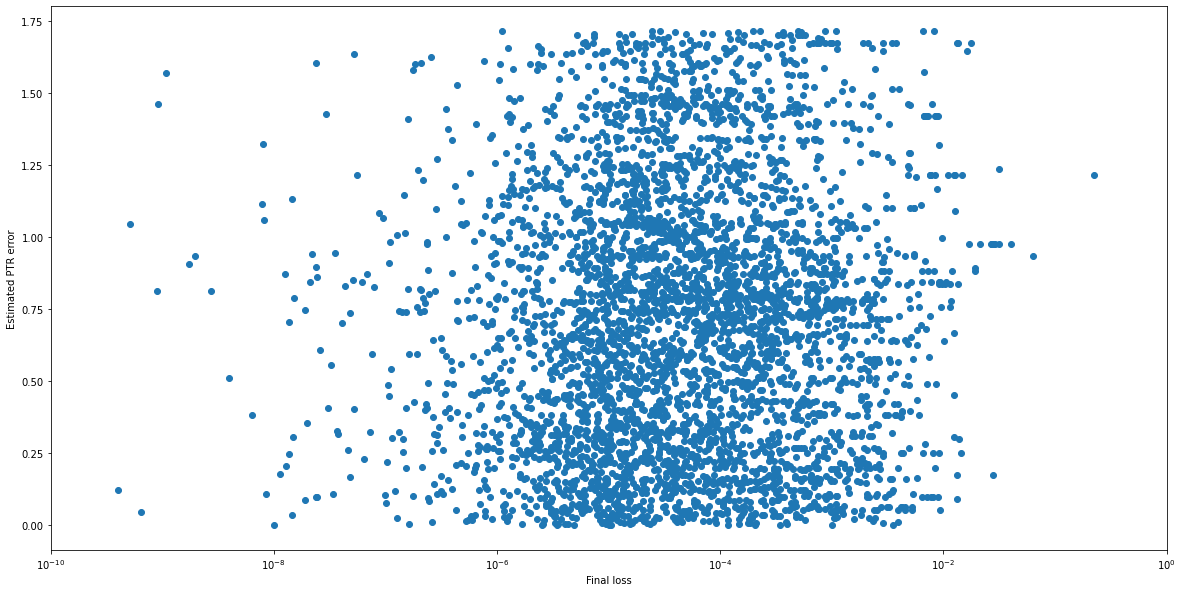

In [18]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(results["final_loss"], results["b_err"])
plt.xlabel("Final loss")
plt.ylabel("Estimated PTR error")
plt.xscale("log")
plt.xlim([1e-10, 1])
# plt.title("PTR predictions can be all over the place")

(0.1, 1000000.0)

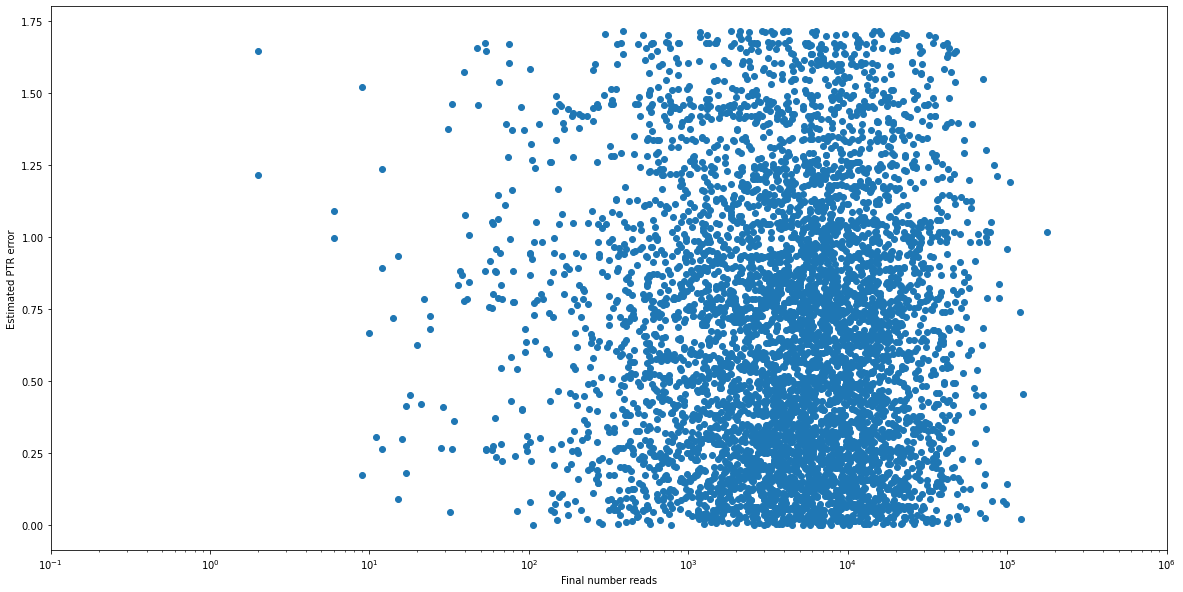

In [9]:
fig = plt.figure(figsize=(20, 10))
plt.scatter(results["n_reads"], results["b_err"])
plt.xlabel("Final number reads")
plt.ylabel("Estimated PTR error")
plt.xscale("log")
plt.xlim([1e-1, 1e6])
# plt.title("PTR predictions can be all over the place")

Text(0, 0.5, 'Count')

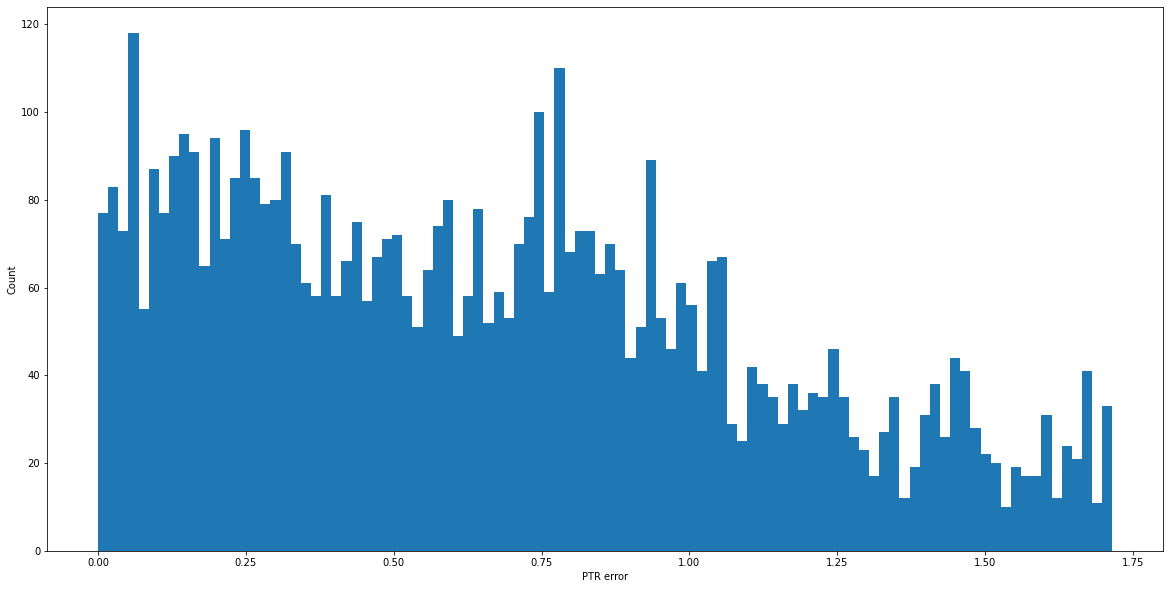

In [10]:
fig = plt.figure(figsize=(20, 10))
plt.hist(results["b_err"], bins=100)
plt.xlabel("PTR error")
plt.ylabel("Count")

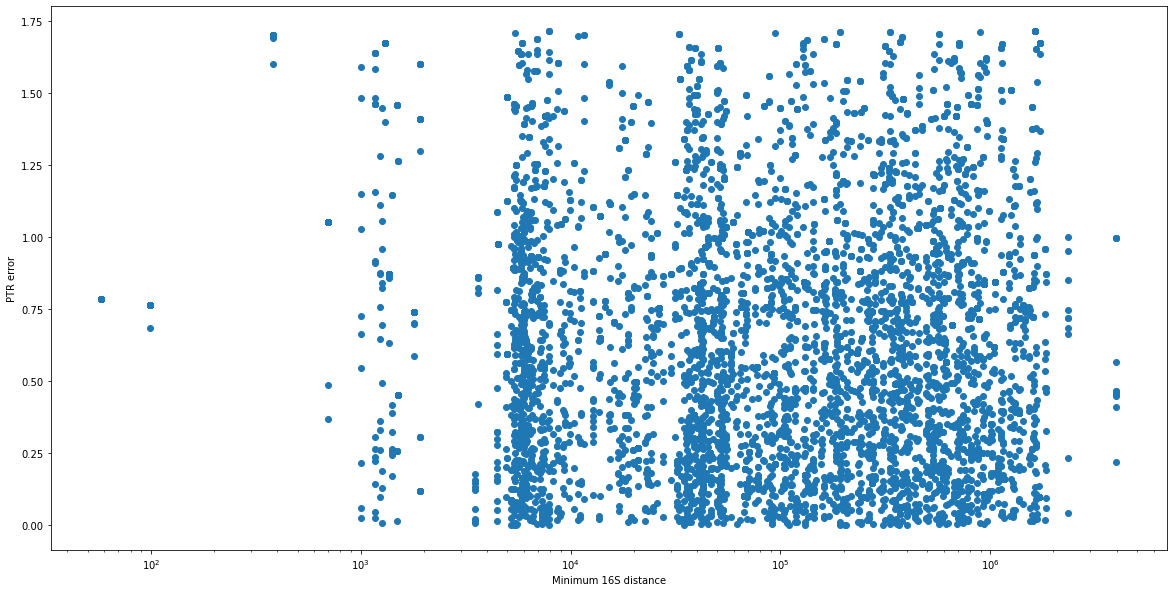

In [33]:
db = RnaDB()

def min_16s_distance(genome):
    """Helper function to get the minimum distance between two 16S genes.    """
    positions = np.array(db[genome]["16s_position"], dtype=float)
    # dists = np.zeros(shape=(len(positions), len(positions)))
    # for i, pos1 in enumerate(positions):
    #     for j, pos2 in enumerate(positions):
    #         if i == j:
    #             dists[i,j] = np.inf # Don't count self
    #         else:
    #             d1 = np.abs(pos1 - pos2),
    #             d2 = np.abs(pos1 - pos2 + db[genome]["size"].max()), # wrap
    #             dists[i, j] = np.min([d1, d2])
    dists1 = np.abs(positions[:, None] - positions[None, :])
    np.fill_diagonal(dists1, np.inf)
    dists2 = np.abs(positions[:, None] - positions[None, :] + db[genome]["size"].max())
    np.fill_diagonal(dists2, np.inf)
    dists = np.min(np.stack([dists1, dists2]), axis=0)

    return dists.min()

fig = plt.figure(figsize=(20, 10))
plt.scatter(
    results["genome"].apply(min_16s_distance),
    results["b_err"],
)
plt.xlabel("Minimum 16S distance")
plt.ylabel("PTR error")
plt.xscale("log")

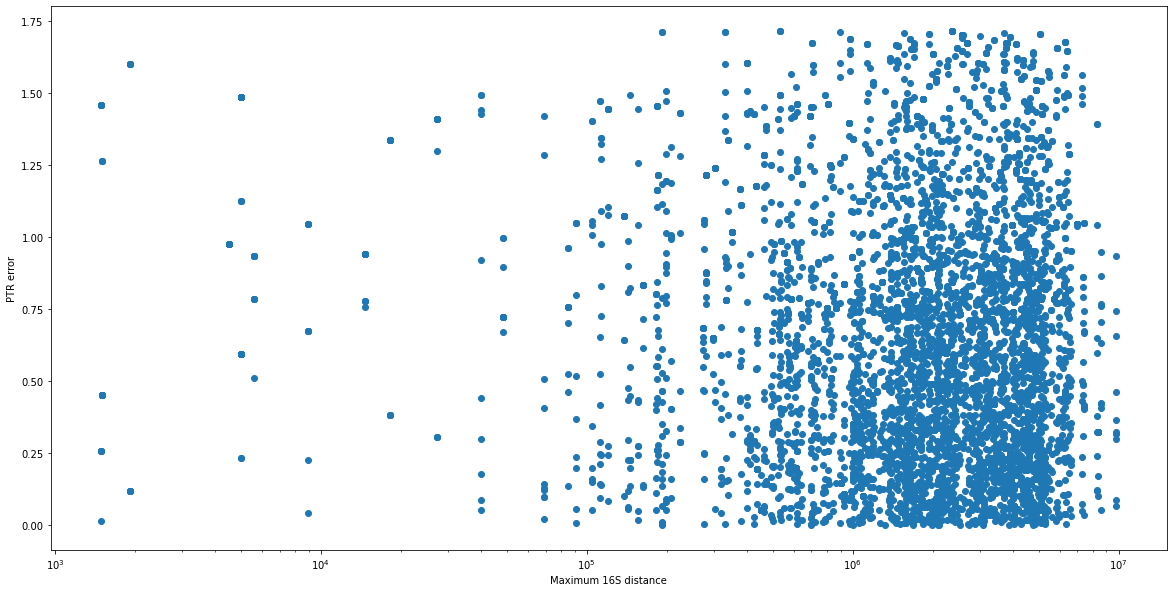

In [34]:
def max_16s_distance(genome):
    """Helper function to get the max distance between two 16S genes.    """
    positions = np.array(db[genome]["16s_position"], dtype=float)
    dists1 = np.abs(positions[:, None] - positions[None, :])
    np.fill_diagonal(dists1, 0)
    dists2 = np.abs(positions[:, None] - positions[None, :] + db[genome]["size"].max())
    np.fill_diagonal(dists2, 0)
    dists = np.min(np.stack([dists1, dists2]), axis=0)

    return dists.max()

fig = plt.figure(figsize=(20, 10))
plt.scatter(
    results["genome"].apply(max_16s_distance),
    results["b_err"],
)
plt.xlabel("Maximum 16S distance")
plt.ylabel("PTR error")
plt.xscale("log")

## Sanity-checking gradients; comparison across solvers

In [7]:
# Something is wrong in this system now. I need to troubleshoot this way more:

# genome_ids = np.random.choice(db.complete_genomes, size=4, replace=False)

# reads, ptrs, abundances, otus = simulate_from_ids(
#     ids=genome_ids,
#     scale=1e5,
#     n_samples=6
# )

solver = TorchSolver(
    genomes=db.generate_genome_objects(genome_ids)[0],
    coverages=otus[0]
)

In [32]:
# Gradient agrees with my closed forms:

# Get torch gradients
solver.a_hat = torch.rand(size=(4,), requires_grad=True)
solver.b_hat = torch.rand(size=(4,), requires_grad=True)
f = solver(solver.a_hat, solver.b_hat)
loss = torch.nn.functional.mse_loss(f, torch.tensor(otus[0], dtype=torch.float32))
loss.backward()
torch_dL_da = solver.a_hat.grad
torch_dL_db = solver.b_hat.grad

# Get analytical gradients
f_np = f.detach().numpy()
a_hat_np = solver.a_hat.detach().numpy()
b_hat_np = solver.b_hat.detach().numpy()
C_np = solver.members.detach().numpy()
D_np = solver.dists.detach().numpy()
E_np = solver.gene_to_seq.detach().numpy()
g = a_hat_np @ C_np + 1 - b_hat_np @ D_np
dL_df = f_np - otus[0]
dL_dg = (2 / len(otus)) * np.exp(g) * (E_np @ dL_df)
dL_da = solver.members @ dL_dg
dL_db = -solver.dists @ dL_dg

print("Torch f:", f)
print("Analytical f:", np.exp(g) @ E_np)

print("Torch dL/da:", torch_dL_da)
print("Analytical dL/da:", dL_da)

print("Torch dL/db:", torch_dL_db)
print("Analytical dL/db:", dL_db)

assert np.allclose(torch_dL_da, dL_da)
assert np.allclose(torch_dL_db, dL_db)

Torch f: tensor([ 2.7370,  3.6430,  4.3385,  3.5012,  3.7245,  4.8535, 29.6439, 11.9577,
         4.6149,  5.9394,  6.9133, 13.8323], grad_fn=<SqueezeBackward3>)
Analytical f: [ 2.73696    3.6430027  4.338527   3.5011532  3.724483   4.853513
 29.643911  11.957653   4.61488    5.9393635  6.913257  13.832276 ]
Torch dL/da: tensor([ -31.2411,  -26.3436, -101.8041,  -16.6243])
Analytical dL/da: tensor([ -31.2411,  -26.3436, -101.8041,  -16.6243], dtype=torch.float64)
Torch dL/db: tensor([9.1526, 3.1139, 4.1989, 4.0977])
Analytical dL/db: tensor([9.1526, 3.1139, 4.1989, 4.0977], dtype=torch.float64)


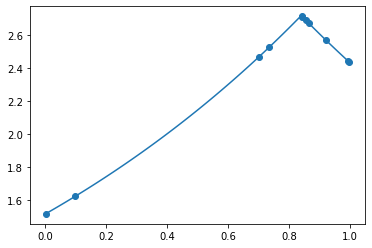

In [56]:
# Maybe we need to simulate differently

def exact_coverage_curve(genome, log_ptr):
    rna_locations = db[genome]["16s_position"] / db[genome]["size"]
    oor = db[genome]["oor_position"].max() / db[genome]["size"] # max is fine
    dists = np.abs(rna_locations - oor)
    return rna_locations, np.exp(1 - log_ptr * dists)

ptr = 2
plt.scatter(*exact_coverage_curve("1566358.3", np.log(ptr)))
x = np.linspace(0, 1, 100)
oor = db["1566358.3"]["oor_position"].max() / db["1566358.3"]["size"].max()
plt.plot(x, np.exp(1 - np.log(ptr) * np.abs(x - oor)))

In [66]:
errs = []
for genome in db.complete_genomes:
    log_ptr = np.log(np.random.rand() + 1)
    _, coverages = exact_coverage_curve(genome, np.log(2))
    solver = TorchSolver(
        genomes=db.generate_genome_objects([genome])[0],
        coverages=np.zeros(db[genome]["md5"].nunique())
    )
    solver.coverages = torch.tensor(
        coverages @ solver.gene_to_seq,
        dtype=torch.float32
    )
    solver.coverages /= solver.coverages.sum()

    a, b, l = solver.train(lr=1, verbose=False)
    print(genome, np.abs(b[0] - log_ptr), sep="\t")



398579.7	0.7577836974804439
1076934.5	0.1420455794930473
1267001.5	0.5239704272205218
546269.5	0.5416660912685245


KeyboardInterrupt: 

In [60]:
db.db

,genome,n_contigs,contig,feature,16s_position,oor_position,size,16s_sequence,md5
6,1566358.3,2,CP010976,fig|1566358.3.rna.126,5768291,4864626,5787303,tctctattggagagtttgatcctggctcaggacgaacgctggcggc...,faaf870b11696fea43ec2d9c838a994f
7,1566358.3,2,CP010976,fig|1566358.3.rna.90,4954926,4864626,5787303,attctattggagagtttgatcctggctcaggacgaacgctggcggc...,c1972f7ea2524059bfda53ff4daaf3d0
8,1566358.3,2,CP010976,fig|1566358.3.rna.123,5760907,4864626,5787303,attctattggagagtttgatcctggctcaggacgaacgctggcggc...,48d447b1df93eb783f37499af2b34164
9,1566358.3,2,CP010976,fig|1566358.3.rna.108,5339582,4864626,5787303,attctattggagagtttgatcctggctcaggacgaacgctggcggc...,c1972f7ea2524059bfda53ff4daaf3d0
10,1566358.3,2,CP010976,fig|1566358.3.rna.3,5759,4864626,5787303,tctctattggagagtttgatcctggctcaggacgaacgctggcggc...,faaf870b11696fea43ec2d9c838a994f
...,...,...,...,...,...,...,...,...,...
7978,903510.3,2,CP002377,fig|903510.3.rna.55,1061286,340647,4916408,agagtttgatcatggctcagattgaacgctggcggcaggcctaaca...,77a903b4bc965f2ca9a34ccc773572e9
7979,903510.3,2,CP002377,fig|903510.3.rna.19,58859,340647,4916408,agagtttgatcatggctcagattgaacgctggcggcaggcctaaca...,5bc0a65936ed7d96bc02cb724e1cd5dd
7980,903510.3,2,CP002377,fig|903510.3.rna.32,387300,340647,4916408,agagtttgatcatggctcagattgaacgctggcggcaggcctaaca...,1b7ac45601266ed9b1f1379d931ab895
7981,903510.3,2,CP002377,fig|903510.3.rna.46,810386,340647,4916408,agagtttgatcatggctcagattgaacgctggcggcaggcctaaca...,8ff71171d7bc1cf309fa5360df79c3e1
